<a href="https://colab.research.google.com/github/24521586-Tan/IT002_OOP_UIT/blob/main/Learning_CL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Contrastive Learning Demo

Contrastive learning is a self-supervised learning technique that aims to learn useful representations of data by bringing similar samples closer together in the embedding space and pushing dissimilar samples further apart. The core idea is to train a model to distinguish between 'positive pairs' (different augmented views of the same sample) and 'negative pairs' (different samples).

### Key Components:
1.  **Encoder Network**: A neural network (e.g., a CNN for images) that maps input data to a lower-dimensional embedding space.
2.  **Projection Head**: A small neural network (e.g., MLP) applied after the encoder to project the embeddings into a space where the contrastive loss is applied.
3.  **Data Augmentation**: Crucial for generating positive pairs. Two different augmentations of the same input image form a positive pair.
4.  **Contrastive Loss Function**: Measures the similarity between positive pairs and dissimilarity with negative pairs. A common choice is the **Normalized Temperature-scaled Cross Entropy (NT-Xent) Loss**.

This demo will walk through a basic implementation using a simple dataset.

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.19.0


### 1. Data Loading and Augmentation

We'll use the CIFAR-10 dataset for this demonstration. A critical part of contrastive learning is generating diverse augmented views of the same image to form positive pairs. We'll define a function to apply random augmentations like random cropping, horizontal flipping, and color jittering.

In [3]:
import torchvision.transforms as T

In [4]:
# Định nghĩa các phép biến đổi ngẫu nhiên
gia_vi_augmentation = T.Compose([
    T.RandomResizedCrop(size=224, scale=(0.08, 1.0)),
    T.ColorJitter(brightness=0.8, contrast=0.8, saturation=0.8, hue=0.2),
    T.RandomGrayscale(p=0.2),
    T.ToTensor()
])

In [5]:
class MayPhanThan:
    def __init__(self, bo_gia_vi):
        # Bước này giống như lắp "túi gia vị" vào máy
        self.bo_gia_vi = bo_gia_vi

    def __call__(self, x):
        # Chạy quy trình gia vị lần 1 -> Ra bản sao A
        view1 = self.bo_gia_vi(x)
        # Chạy quy trình gia vị lần 2 -> Ra bản sao B
        view2 = self.bo_gia_vi(x)

        # Trả về danh sách chứa 2 bản sao
        return [view1, view2]

In [6]:
# Tạo ra một cái máy thật (may_in) từ bản thiết kế (MayPhanThan)
# Và đưa bộ gia vị vào cho nó dùng
may_in = MayPhanThan(gia_vi_augmentation)

In [7]:
from torchvision.datasets import CIFAR10

# Nhập kho ảnh mẫu và gắn máy phân thân vào làm "người gác cổng"
kho_du_lieu = CIFAR10(
    root='./data',           # Thư mục để tải và lưu ảnh
    train=True,              # Xác định đây là dữ liệu để học (training)
    download=True,           # Tự động tải về nếu trong máy chưa có
    transform=may_in         # Gắn máy phân thân (may_in) vào đây
)

In [8]:
from torch.utils.data import DataLoader

# Tạo người vận chuyển để bốc từng nhóm 32 tấm ảnh một lúc
nguoi_van_chuyen = DataLoader(
    kho_du_lieu,
    batch_size=32,   # Mỗi chuyến chở 32 ảnh gốc
    shuffle=True     # Xáo trộn ảnh lên cho khách quan
)

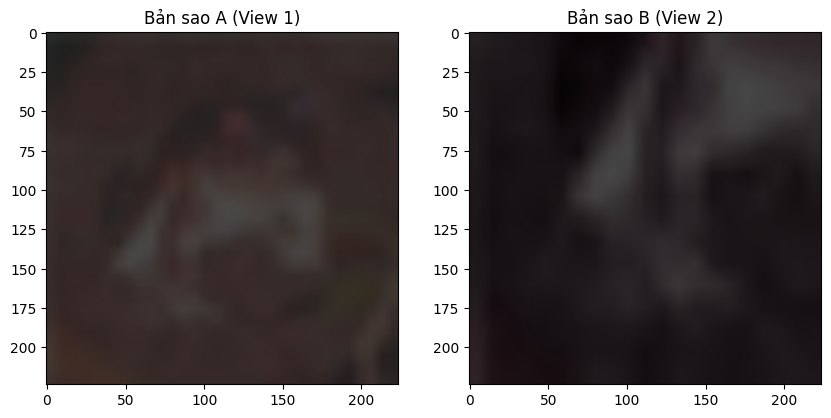

In [9]:
import matplotlib.pyplot as plt

# 1. Lấy thử phần tử đầu tiên từ kho dữ liệu
# Vì đã cài transform=may_in, nó sẽ trả về một cặp [view1, view2]
cap_ban_sao, nhan = kho_du_lieu[0]
view1, view2 = cap_ban_sao

# 2. Hiển thị 2 bản sao lên màn hình
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Chuyển từ dạng số (Tensor) về dạng ảnh để nhìn được
ax[0].imshow(view1.permute(1, 2, 0))
ax[0].set_title("Bản sao A (View 1)")
ax[1].imshow(view2.permute(1, 2, 0))
ax[1].set_title("Bản sao B (View 2)")

plt.show()

In [10]:
import torch.nn as nn
from torchvision import models

# 1. Triệu hồi bộ não ResNet18
# weights=None nghĩa là mình lấy cái khung thôi, để nó tự học từ đầu với ảnh của mình
bo_nao_resnet = models.resnet18(weights=None)

# 2. Xem thử đầu ra của nó là gì
print(f"Số lượng đặc điểm đầu ra mặc định: {bo_nao_resnet.fc.in_features}")

Số lượng đặc điểm đầu ra mặc định: 512


In [11]:
# 1. Cắt bỏ lớp cuối cùng (fc - fully connected) của ResNet
# Chúng ta giữ lại mọi thứ phía trước, chỉ bỏ cái đuôi cũ đi
bo_nao_resnet.fc = nn.Sequential(
    nn.Linear(512, 512), # Lớp trung gian: nhận 512, giữ nguyên 512
    nn.ReLU(),           # Hàm kích hoạt: giúp máy học được các quy luật phức tạp
    nn.Linear(512, 128)  # Lớp đầu ra của bộ lọc: nén xuống còn 128 con số
)

print(bo_nao_resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
class SimCLR_Model(nn.Module):
    def __init__(self, base_model):
        super(SimCLR_Model, self).__init__()
        # 1. Phần xương sống (Backbone) chính là ResNet18 đã phẫu thuật
        self.backbone = base_model

    def forward(self, x):
        # 2. Khi cho ảnh vào, nó sẽ đi qua bộ não và bộ lọc để ra 128 con số
        return self.backbone(x)

# Tạo mô hình thực tế để chuẩn bị đi học
mo_hinh_final = SimCLR_Model(bo_nao_resnet)

In [13]:
import torch.nn.functional as F

def tinh_do_tuong_dong(features):
    # features chính là ma trận 64x128 của ông
    # F.cosine_similarity sẽ đo góc giữa các vector hàng

    # Bước này tính độ tương đồng của mọi cặp ảnh trong batch
    # Kết quả trả về ma trận 64x64
    similarity_matrix = F.cosine_similarity(features.unsqueeze(1), features.unsqueeze(0), dim=2)
    return similarity_matrix

In [14]:
import torch
import torch.nn as nn

def simclr_loss(similarity_matrix, temperature=0.5):
    n = similarity_matrix.shape[0] # n = 64 (tổng số ảnh)

    # --- BƯỚC 1: Loại bỏ việc tự so sánh với chính mình ---
    # Chúng ta tạo một cái mặt nạ (mask) để bỏ đi đường chéo của ma trận
    # Vì ô (0,0), (1,1)... luôn bằng 1.0, không có giá trị học tập
    mask = torch.eye(n, dtype=torch.bool).to(similarity_matrix.device)

    # Lấy những ô không nằm trên đường chéo, kết quả mỗi hàng còn 63 số
    logits = similarity_matrix[~mask].view(n, n - 1)

    # Chia cho nhiệt độ để phóng đại sự khác biệt
    logits = logits / temperature

    # --- BƯỚC 2: Tạo "Đáp án đúng" (Labels) ---
    # Ông nhớ quy tắc: Mèo A (vị trí 0) có bạn thân là Mèo B (vị trí 32)
    # Sau khi bỏ đường chéo, vị trí của bạn thân sẽ bị dịch chuyển một chút
    # Đoạn này máy tính sẽ tự tính toán để biết "số thứ mấy trong 63 đứa là bạn mình"
    labels = torch.cat([torch.arange(n//2, n), torch.arange(0, n//2)])
    labels = (labels < torch.arange(n)).long() * labels + (labels >= torch.arange(n)).long() * (labels - 1)
    labels = labels.to(similarity_matrix.device)

    # --- BƯỚC 3: Tính toán sự trừng phạt ---
    # Dùng CrossEntropy: Nếu vị trí "bạn thân" có điểm thấp, Loss sẽ cực cao
    criterion = nn.CrossEntropyLoss()
    loss = criterion(logits, labels)

    return loss

In [15]:
import torch.optim as optim

# 1. Chọn người hướng dẫn Adam để cập nhật bộ não mô hình
nguoi_huong_dan = optim.Adam(mo_hinh_final.parameters(), lr=0.001)

# 2. Đưa mô hình vào chế độ "đang học"
mo_hinh_final.train()

# 3. Chuyển mô hình sang GPU nếu có (để chạy cho nhanh)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mo_hinh_final.to(device)

SimCLR_Model(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [16]:
# Cho máy chạy thử 1 vòng (Epoch)
for epoch in range(1):
    tong_loss = 0

    # Bốc từng chuyến xe từ người vận chuyển
    for i, (anh_pairs, _) in enumerate(nguoi_van_chuyen):
        # 1. Chuyển ảnh lên GPU/CPU
        view1, view2 = anh_pairs[0].to(device), anh_pairs[1].to(device)

        # 2. Gom 2 bản sao lại thành 1 batch lớn 64 ảnh
        anh_batch = torch.cat([view1, view2], dim=0)

        # 3. Cho ảnh đi qua bộ não để lấy 128 đặc điểm
        features = mo_hinh_final(anh_batch)

        # 4. Tính ma trận tương đồng & Tính lỗi
        sim_matrix = tinh_do_tuong_dong(features)
        loss = simclr_loss(sim_matrix)

        # 5. Người hướng dẫn ra tay sửa lỗi
        nguoi_huong_dan.zero_grad() # Xóa bảng nháp cũ
        loss.backward()             # Tính toán hướng sửa
        nguoi_huong_dan.step()      # Thực hiện xoay nút vặn

        tong_loss += loss.item()

        if i % 10 == 0:
            print(f"Chuyến xe {i}, Mức độ lỗi hiện tại: {loss.item():.4f}")

    print(f"===> Kết thúc vòng 1, Lỗi trung bình: {tong_loss/len(nguoi_van_chuyen):.4f}")

KeyboardInterrupt: 

In [17]:
# 1. Lấy phần xương sống đã được huấn luyện từ mo_hinh_final
xuong_song = mo_hinh_final.backbone

# 2. Đóng băng xương sống (Không cho học thêm nữa, chỉ dùng kiến thức cũ)
for param in xuong_song.parameters():
    param.requires_grad = False

# 3. Thay cái "đầu lọc" 128 chiều bằng một "đầu phân loại" mới
# Giả sử chúng ta có 10 loại vật thể (như tập CIFAR-10)
xuong_song.fc = nn.Linear(512, 10)

mo_hinh_test = xuong_song.to(device)

In [19]:
import torchvision
import torchvision.transforms as transforms
import torch

# 1. Định nghĩa cách xử lý ảnh (Resize và Chuẩn hóa)
transform_test = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# 2. Tải tập dữ liệu CIFAR-10 (Tập dữ liệu thực tế có nhãn)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# 3. Tạo bộ nạp dữ liệu - Đây chính là 'testloader' mà máy báo thiếu
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

print("Đã khởi tạo testloader thành công!")

Đã khởi tạo testloader thành công!


In [21]:
import torch.nn as nn
import torch.optim as optim

# 1. Định nghĩa lại mô hình test (Lấy xương sống từ mo_hinh_final)
# Đảm bảo mo_hinh_final đã được định nghĩa ở các ô trước
mo_hinh_test = mo_hinh_final.backbone

# 2. Thay lớp cuối cùng để phân loại 10 lớp của CIFAR-10
mo_hinh_test.fc = nn.Linear(512, 10)
mo_hinh_test = mo_hinh_test.to(device)

# 3. Chỉ cho phép lớp cuối cùng (fc) được học, đóng băng phần còn lại
for name, param in mo_hinh_test.named_parameters():
    if "fc" not in name:
        param.requires_grad = False

# 4. Thiết lập người hướng dẫn cho lớp cuối cùng
optimizer_test = optim.Adam(mo_hinh_test.fc.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# 5. Vòng lặp huấn luyện siêu tốc
print("Bắt đầu huấn luyện đầu phân loại...")
mo_hinh_test.train()
for epoch in range(2):
    running_loss = 0.0
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)

        # Dự đoán nhãn
        outputs = mo_hinh_test(images)
        loss = criterion(outputs, labels)

        # Cập nhật lớp fc
        optimizer_test.zero_grad()
        loss.backward()
        optimizer_test.step()

        running_loss += loss.item()
    print(f"Epoch {epoch+1} hoàn tất. Lỗi trung bình: {running_loss/len(testloader):.4f}")

Bắt đầu huấn luyện đầu phân loại...
Epoch 1 hoàn tất. Lỗi trung bình: 2.1790
Epoch 2 hoàn tất. Lỗi trung bình: 1.9673


In [22]:
mo_hinh_test.eval() # Chuyển sang chế độ đánh giá
dung = 0
tong = 0

with torch.no_grad(): # Không cần tính đạo hàm lúc này
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)

        # Dự đoán
        outputs = mo_hinh_test(images)
        _, du_doan = torch.max(outputs.data, 1) # Lấy nhãn có xác suất cao nhất

        tong += labels.size(0)
        dung += (du_doan == labels).sum().item()

print(f'Độ chính xác của bộ não SimCLR trên 10.000 ảnh test: {100 * dung / tong:.2f}%')

Độ chính xác của bộ não SimCLR trên 10.000 ảnh test: 33.46%


In [23]:
# 1. Mở băng toàn bộ mô hình
for param in mo_hinh_test.parameters():
    param.requires_grad = True

# 2. Dùng tốc độ học (Learning Rate) SIÊU NHỎ
# Để không làm hỏng những gì SimCLR đã dày công tự học
optimizer_fine_tune = optim.Adam(mo_hinh_test.parameters(), lr=0.0001)

# 3. Huấn luyện thêm 1-2 vòng nữa
mo_hinh_test.train()
for epoch in range(1):
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = mo_hinh_test(images)
        loss = criterion(outputs, labels)

        optimizer_fine_tune.zero_grad()
        loss.backward()
        optimizer_fine_tune.step()
    print(f"Fine-tuning Epoch {epoch+1} hoàn tất!")

Fine-tuning Epoch 1 hoàn tất!
Fine-tuning Epoch 2 hoàn tất!


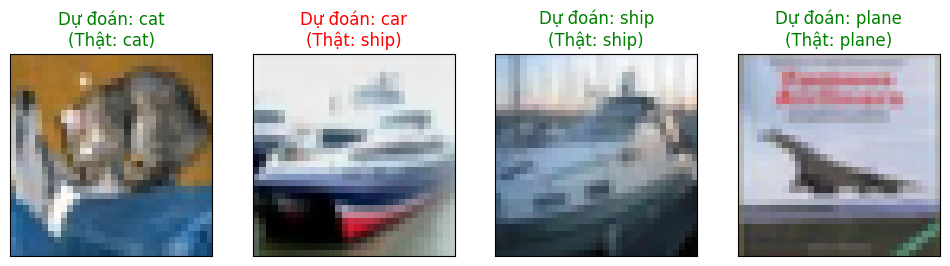

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Danh sách tên các lớp của CIFAR-10 để hiển thị chữ thay vì số
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# 2. Lấy một batch ảnh từ testloader
dataiter = iter(testloader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# 3. Cho mô hình dự đoán
mo_hinh_test.eval()
with torch.no_grad():
    outputs = mo_hinh_test(images)
    _, predicted = torch.max(outputs, 1)

# 4. Hiển thị 4 tấm ảnh đầu tiên để kiểm tra
fig = plt.figure(figsize=(12, 4))
for idx in range(4):
    ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])

    # Chuyển tensor ảnh về định dạng numpy để vẽ (Unnormalize)
    img = images[idx].cpu().numpy().transpose((1, 2, 0))
    img = img * 0.5 + 0.5 # Đưa về khoảng [0, 1]

    plt.imshow(img)

    # Đặt màu tiêu đề: Xanh nếu đúng, Đỏ nếu sai
    color = "green" if predicted[idx] == labels[idx] else "red"
    ax.set_title(f"Dự đoán: {classes[predicted[idx]]}\n(Thật: {classes[labels[idx]]})", color=color)

plt.show()